# Outlier Detection with YData Fabric's Outlier Engine

In this notebook we will explore the capabilities of YData Fabric's Outlier Engine and how you can harness it to quickly detect, cluster and visualise outliers in your dataset.

We will explore outlier detection with YData Fabric in these key stages:
1. Discovering the Outlier Engine.
2. Accessing the outliers.
3. Managing the Outlier Pipelines.
    1. The Variance Pipeline.
    2. Visualising the Outliers.
    3. The Standard Deviation Pipeline.
4. Creating a bespoke outlier detection pipeline.



## Make the Imports

In [1]:
from dataclasses import fields, asdict
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data

from ydata.metadata import Metadata
from ydata.dataset import Dataset

from ydata.quality.outlier import OutlierEngine, OutlierSteps, OutlierPipeline
from ydata.quality.outlier.detection import IsolationForest, StandardDeviation
from ydata.quality.outlier.projection import PCA, ICA
from ydata.quality.outlier.clustering import HDBSCANClustering

## Generate an Outlier Dataset

In [2]:
contamination = 0.1  # fraction of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points
n_features = 3
X_, _, y, _ = generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=n_features,
                      contamination=contamination,
                      random_state=42)
df = pd.DataFrame(X_, columns=[f'col_{i}' for i in range(n_features)])
df[f'col_{n_features}'] = 1
dataset = Dataset(df)
metadata = Metadata(dataset)

[########################################] | 100% Completed | 211.96 ms


Inspect the dataset:

In [3]:
dataset.head()

,col_0,col_1,col_2,col_3
0,6.433659,5.509168,5.044698,1
1,7.708065,5.924536,5.259220,1
2,5.293991,5.671262,5.615091,1
3,6.130929,6.185903,6.094106,1
4,7.166309,7.227191,4.054708,1


Inspect the metadata:

In [4]:
print(metadata)

Metadata Summary 
 
Dataset type: TABULAR
Dataset attributes: 
Number of columns: 4
% of duplicate rows: 0
Target column: 

Column detail: 
  Column  Data type Variable type
0  col_0  numerical         float
1  col_1  numerical         float
2  col_2  numerical         float
3  col_3  numerical           int

Warnings: 
       Warning                                  Columns
0     skewness                    [col_0, col_1, col_2]
1     constant                                  [col_3]
2  correlation  [col_0|col_1, col_0|col_2, col_1|col_2]
3       unique                    [col_0, col_1, col_2]



## Discover the Outlier Engine

The most powerful way to detect and explore outliers in your dataset is to use the Outlier Engine. 

The outlier engine runs outlier detection pipelines, in which each pipeline is responsible for detecting outliers according to a specified metric or method. 

The outlier engine is pre-configured but can be tuned to operate bespoke pipelines.

In [5]:
outlier_engine = OutlierEngine()

In [6]:
outliers = outlier_engine.fit_predict(dataset, metadata)  # Use the default detection pipelines

The output of the `fit_predict` method is a list, `OutlierCluster`, which can be futher explored to determine the nature of the detected outliers.

The lightweight `OutlierCluster` object only stores the specified elements' index, with the pipeline's name in the field `pipeline`.

## Accessing the Outliers

We can simply explore the outliers detected by the engine by inspecting the output of the `fit_predict` method.

In [7]:
outliers

[OutlierCluster(index=Int64Index([180, 182, 183, 187, 189, 195, 196, 197, 198, 199], dtype='int64'), pipeline='std', is_outlier=True),
 OutlierCluster(index=Int64Index([181, 184, 186, 188, 190, 191, 192, 193], dtype='int64'), pipeline='std', is_outlier=True),
 OutlierCluster(index=Int64Index([194], dtype='int64'), pipeline='std', is_outlier=True),
 OutlierCluster(index=Int64Index([29, 42, 61, 66, 181, 193, 194], dtype='int64'), pipeline='variance', is_outlier=True),
 OutlierCluster(index=Int64Index([182, 184, 187, 188, 198, 199], dtype='int64'), pipeline='variance', is_outlier=True),
 OutlierCluster(index=Int64Index([180, 189, 191, 192, 195, 196, 197], dtype='int64'), pipeline='variance', is_outlier=True)]

Specific outlier clusters can be accessed via indexing:

In [8]:
outliers[0]

OutlierCluster(index=Int64Index([180, 182, 183, 187, 189, 195, 196, 197, 198, 199], dtype='int64'), pipeline='std', is_outlier=True)

We can either retrieve the outliers using the `index` field of the `OutlierCluster` object or by using the method `OutlierCluster.get_outliers` with the dataset:

In [9]:
df.iloc[outliers[0].index]

,col_0,col_1,col_2,col_3
180,4.209810,-4.945349,3.670379,1
182,-5.781090,2.363538,5.967066,1
183,4.759323,0.911981,5.008747,1
187,-3.539069,5.615929,2.531430,1
189,2.486761,3.213354,-4.952518,1
195,1.273223,3.531473,-4.719609,1
196,4.208730,2.951694,-1.097780,1
197,5.195257,5.891154,-3.539978,1
198,-1.449257,5.117393,2.659159,1
199,-5.422864,3.378174,3.935291,1


In [10]:
outliers[0].get_outliers(dataset)

,col_0,col_1,col_2,col_3
180,4.209810,-4.945349,3.670379,1
182,-5.781090,2.363538,5.967066,1
183,4.759323,0.911981,5.008747,1
187,-3.539069,5.615929,2.531430,1
189,2.486761,3.213354,-4.952518,1
195,1.273223,3.531473,-4.719609,1
196,4.208730,2.951694,-1.097780,1
197,5.195257,5.891154,-3.539978,1
198,-1.449257,5.117393,2.659159,1
199,-5.422864,3.378174,3.935291,1


## Manage the Outlier Pipelines

We will showcase the variance and standard deviation pipelines in this example:

1. Variance Pipeline: find outliers based on their representation in the variance space.
2. Standard Deviation Pipeline: find outliers based on how far they are to the mean compared to the standard deviation.

### The Variance Pipeline

Let's explore the pipeline that detects outliers according to the variance. As shown by a `print`, it consists of a Principal Component Analysis (PCA) i.e., a projection that maps the dataset onto a 2D basis that explains the most the variance in the dataset. Therefore, outliers in this space are, by definition, the points in the dataset that explain the least amount of variance. 

We can print the pipeline to the console to understand how it works:

In [11]:
outlier_engine.pipelines['variance']

OutlierSteps(projection=<ydata.quality.outlier.projection.pca.PCA object at 0x7f89a6828460>, detection=ECOD(), clustering=<ydata.quality.outlier.clustering.hdbscan.HDBSCANClustering object at 0x7f89a68284f0>, representation=<class 'ydata.quality.outlier.prototype.Identity'>)

On top of accessing all of the clusters at the same time for both ranking and filtering, it is also possible to access the outlier cluster of a particular pipeline/outlier detection method:

In [12]:
variance_clusters = outlier_engine.get_outlier_clusters()['variance']
variance_clusters

[OutlierCluster(index=Int64Index([29, 42, 61, 66, 181, 193, 194], dtype='int64'), pipeline='variance', is_outlier=True),
 OutlierCluster(index=Int64Index([182, 184, 187, 188, 198, 199], dtype='int64'), pipeline='variance', is_outlier=True),
 OutlierCluster(index=Int64Index([180, 189, 191, 192, 195, 196, 197], dtype='int64'), pipeline='variance', is_outlier=True)]

Each pipeline has a method called `represent`, which turns a dataset into a dataframe that can be directly used for both plots and other forms of direct interpretation.

There is an `outlier_score` column, which has a negative value for non-outliers and a positive value for outliers in addition to a `cluster` column, which indicates the point's associated cluster, which would be 'None' if a point isn't an outlier.

In [13]:
representation = outlier_engine.pipelines['variance'].represent(dataset)

In [14]:
representation

,0,1,outlier_score,cluster
0,-0.446356,-1.036067,-0.627523,None
1,-1.605278,-1.703312,-0.286409,None
2,-0.094986,0.188692,-0.831816,None
3,-1.162007,0.030962,-0.972606,None
4,-1.004303,-1.526044,-0.509641,None
...,...,...,...,...
195,9.897971,-3.534330,0.337957,2
196,5.889505,-3.831989,0.161103,2
197,5.580969,-4.902077,0.376628,2
198,6.520640,3.266900,0.209810,1


### Visualise the Outliers

We can then visualise all of the points together in the representation space:

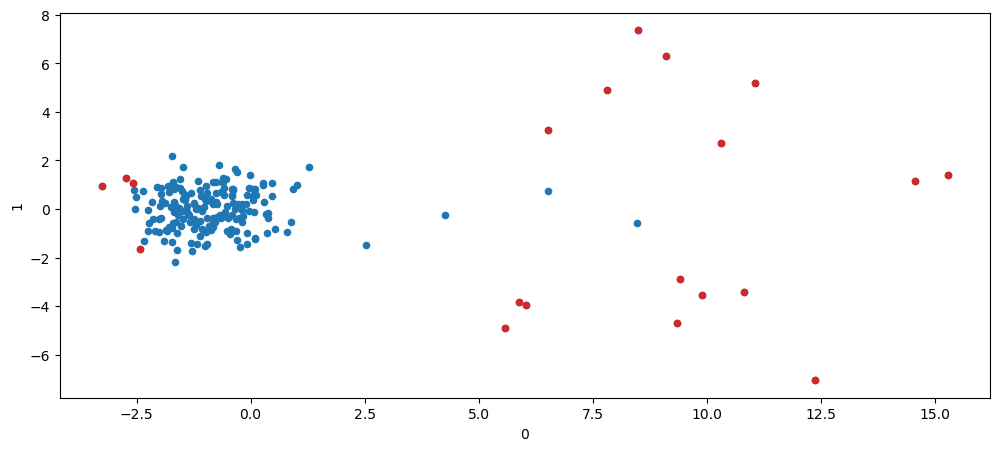

In [15]:
fig, ax = plt.subplots(figsize=[12, 5])

representation.plot.scatter(
    ax=ax,
    x=0, 
    y=1,
)
representation.dropna().plot.scatter(
        ax=ax,
        x=0, 
        y=1, 
        color='tab:red',
    )

plt.show()

To make the visualisation clearer we can format the outlier's colour to represent its cluster, and its size to correspond with its outlier score.

The normal points are plotted as a reference and are formatted to be smaller and more transparent so that the outliers can be seen more clearly.

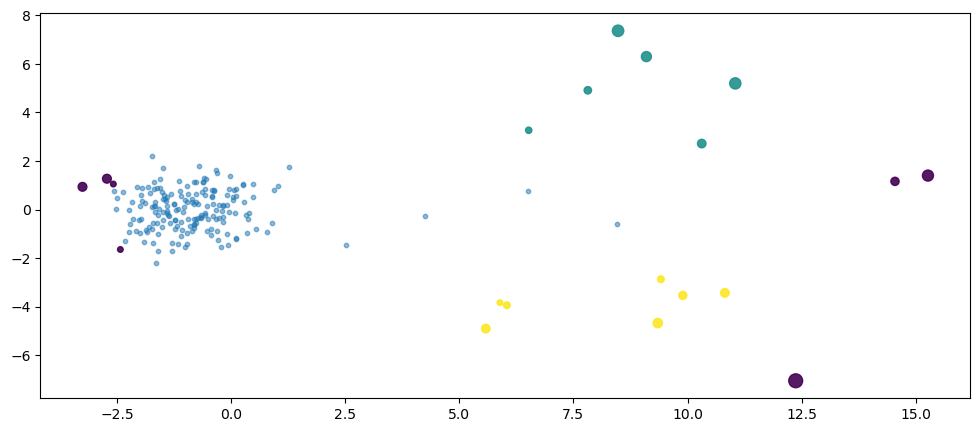

In [16]:
fig, ax = plt.subplots(figsize=[12, 5])

non_outliers = representation[representation['cluster'].isna()]
outliers_df = representation.dropna()

ax.scatter(
    x=non_outliers[0], 
    y=non_outliers[1],
    color='tab:blue',
    s=10,
    alpha=0.5
)

ax.scatter(
        x=outliers_df[0], 
        y=outliers_df[1],
        c=outliers_df.cluster,
        s=100 * outliers_df.outlier_score,
        alpha=0.9
    )
plt.show()


To help the user, we provide a `plot` method which returns the exact same plot as above.

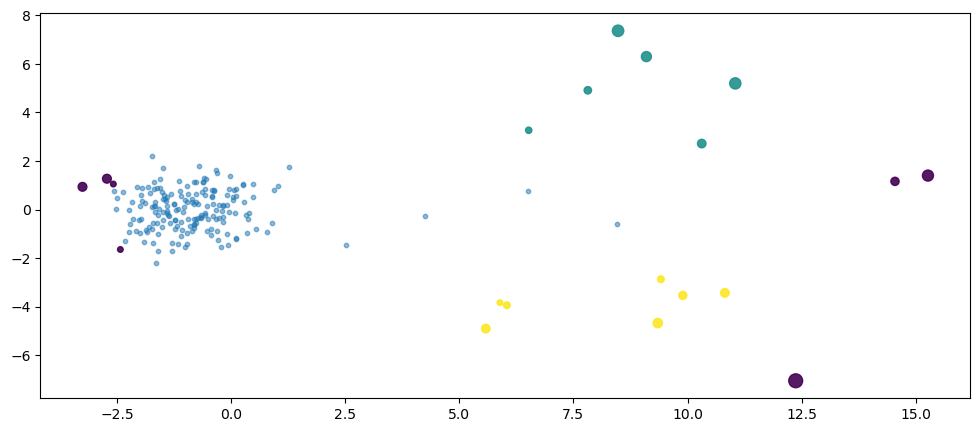

In [17]:
outlier_engine.pipelines['variance'].plot(dataset)

 You can also specify an `Axis` object as a parameter from the Matlibplot library to further customise this graph.

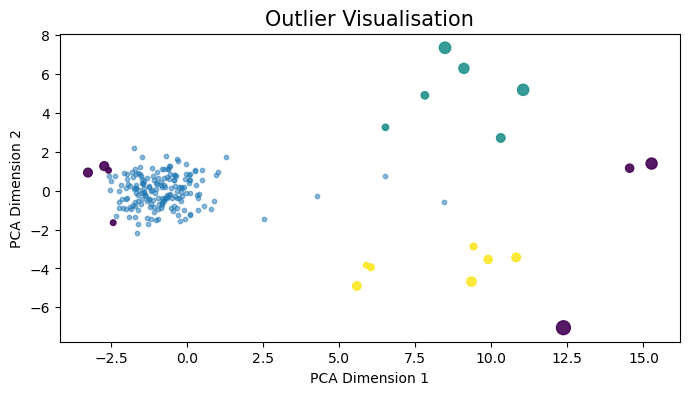

In [18]:
fig, ax = plt.subplots(figsize=[8, 4])
ax.set_title('Outlier Visualisation', fontdict={'fontsize': 15, 'fontweight': 'medium'})
ax.set_xlabel('PCA Dimension 1', fontsize=10)
ax.set_ylabel('PCA Dimension 2', fontsize=10)

outlier_engine.pipelines['variance'].plot(dataset, ax = ax)

In addition, you can edit the `non_outliers` parameter to control the colour of the normal points.

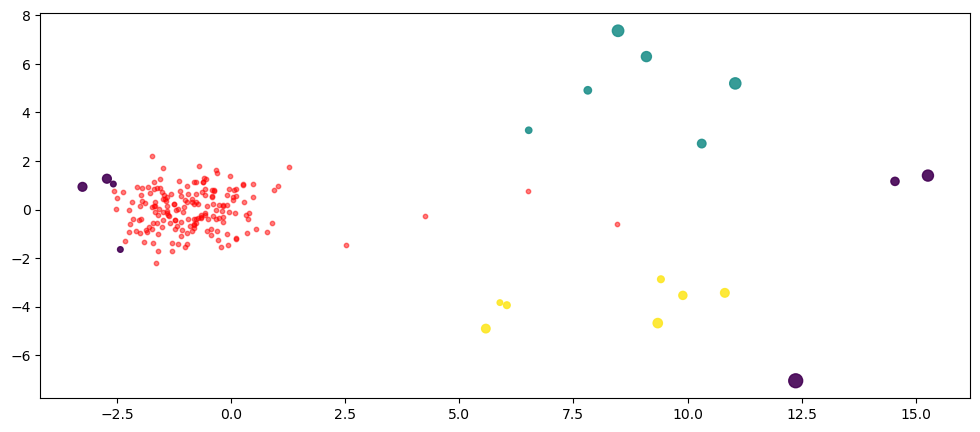

In [19]:
outlier_engine.pipelines['variance'].plot(dataset, non_outliers={'color': 'red'})

To visualise the outliers in the original space and not in the representation space, simply specify the axes you wish to plot on.

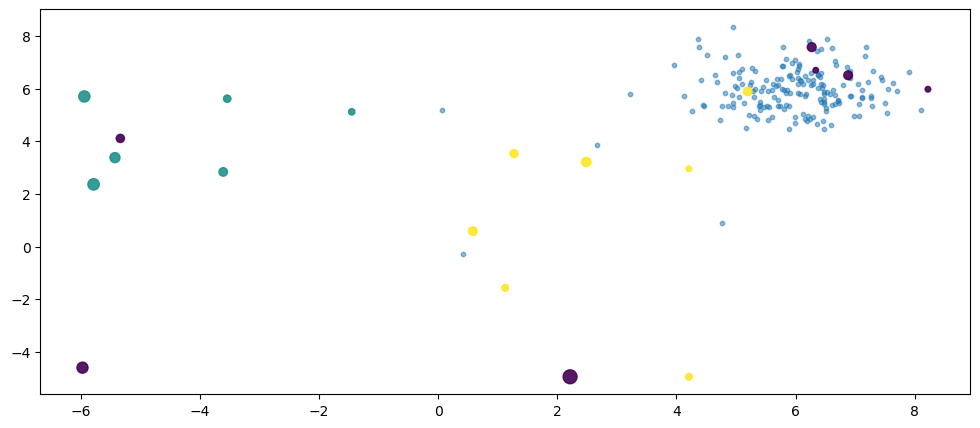

In [20]:
non_outliers = representation[representation['cluster'].isna()]
outliers_df = representation.dropna()

fig, ax = plt.subplots(figsize=[12, 5])

ax.scatter(
    x=df.iloc[non_outliers.index].col_0, 
    y=df.iloc[non_outliers.index].col_1,
    color='tab:blue',
    s=10,
    alpha=0.5
)

ax.scatter(
        x=df.iloc[outliers_df.index].col_0, 
        y=df.iloc[outliers_df.index].col_1,
        c=outliers_df.cluster,
        s=100 * outliers_df.outlier_score,
        alpha=0.9
    )

plt.show()

### The Standard Deviation Pipeline

The standard deviation pipeline detects points above a specific ratio ($2$ by default) of the standard deviation from the mean as outliers.

Each point's score is the ratio of the number of columns whose value exceeds $2\sigma$ of its mean. For instance, a point with a score of $0$ means that no features are beyond $2\sigma$. A point with a score of $0.5$ means half of its features are beyond $2\sigma$.

In [21]:
std_clusters = outlier_engine.get_outlier_clusters()['std']

In [22]:
std_clusters

[OutlierCluster(index=Int64Index([180, 182, 183, 187, 189, 195, 196, 197, 198, 199], dtype='int64'), pipeline='std', is_outlier=True),
 OutlierCluster(index=Int64Index([181, 184, 186, 188, 190, 191, 192, 193], dtype='int64'), pipeline='std', is_outlier=True),
 OutlierCluster(index=Int64Index([194], dtype='int64'), pipeline='std', is_outlier=True)]

The representation for this pipeline shows the ratio of standard deviation for each feature and each row. Like all the representations, it specifies the `outlier_score` and the cluster each points belong to.

It is easy to interpret. For instance:
- row 0 has all of its features below $2\sigma$ and thus a score of $0$. It is not an outlier.
- row 196 has `col_3` above $2\sigma$ and thus, it has a score of $0.25$ (1 columns out 4). It is an outlier.

In [23]:
representation = outlier_engine.pipelines['std'].represent(dataset)
representation

,col_0,col_1,col_2,col_3,outlier_score,cluster
0,0.440293,0.041921,0.171861,0.0,0.00,None
1,0.967227,0.189643,0.077724,0.0,0.00,None
2,0.030929,0.048445,0.078441,0.0,0.00,None
3,0.315122,0.335354,0.288644,0.0,0.00,None
4,0.743225,0.915866,0.606292,0.0,0.00,None
...,...,...,...,...,...,...
195,1.693411,1.144473,4.456667,0.0,0.25,0
196,0.479656,1.467697,2.867324,0.0,0.25,0
197,0.071753,0.171033,3.939018,0.0,0.25,0
198,2.819085,0.260333,1.218691,0.0,0.25,0


The standard deviation pipeline does not project the data into another space and therefore, we propose another representation which helps to understand why the outliers are being detected as outliers.   


In particular, for each column, we plot the ratio of standard deviation for each point and each feature and the red dotted line represents the threshold. Every point above the threshold is an outlier.

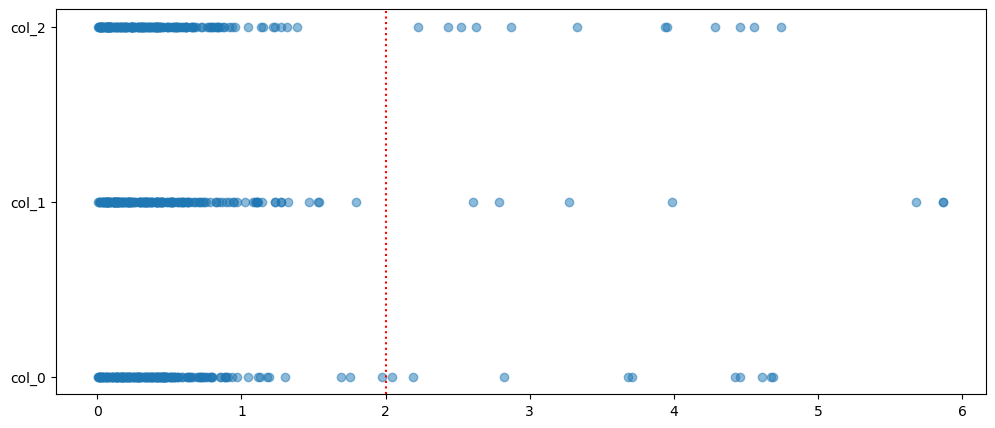

In [24]:
outlier_engine.pipelines['std'].plot(dataset)

Like any other pipeline designed for the outlier engine, it is possible to plot the outliers in the original space.

For instance, if we plot against the first and second dimension, one point doesn't seem to be an outlier.

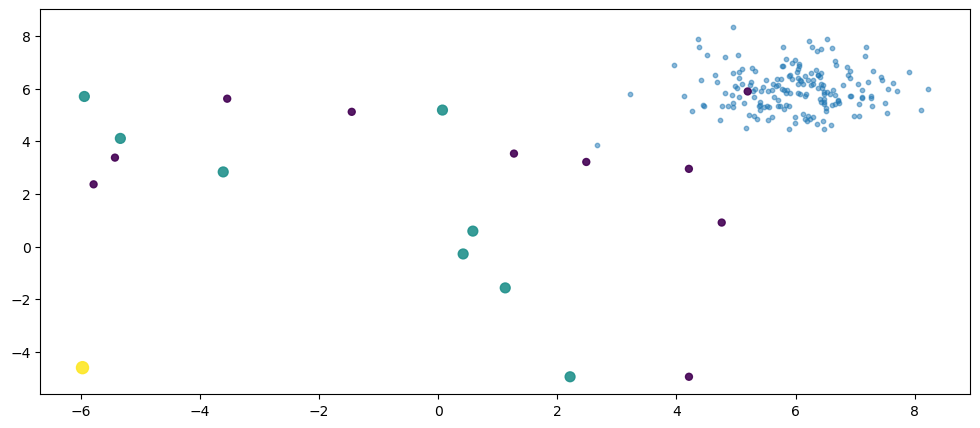

In [25]:
non_outliers = representation[representation['cluster'].isna()]
outliers_df = representation.dropna()

fig, ax = plt.subplots(figsize=[12, 5])

ax.scatter(
    x=df.iloc[non_outliers.index].col_0, 
    y=df.iloc[non_outliers.index].col_1,
    color='tab:blue',
    s=10,
    alpha=0.5
)

ax.scatter(
        x=df.iloc[outliers_df.index].col_0, 
        y=df.iloc[outliers_df.index].col_1,
        c=outliers_df.cluster,
        s=100 * outliers_df.outlier_score,
        alpha=0.9
    )

plt.show()

However, if we plot against the second and third dimension, this point clearly becomes an outlier. For this reason, the representation table and the representation plot that we offer is a much clearer way to determine if a point is an outlier.

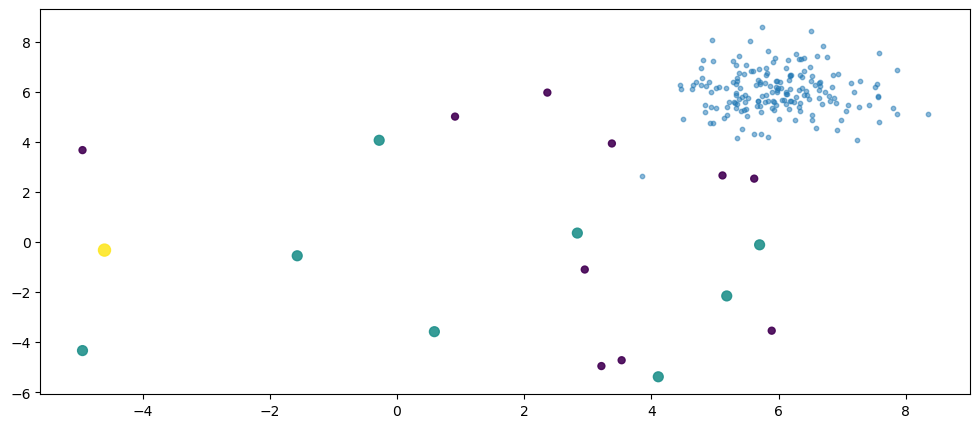

In [26]:
non_outliers = representation[representation['cluster'].isna()]
outliers_df = representation.dropna()

fig, ax = plt.subplots(figsize=[12, 5])

ax.scatter(
    x=df.iloc[non_outliers.index].col_1, 
    y=df.iloc[non_outliers.index].col_2,
    color='tab:blue',
    s=10,
    alpha=0.5
)

ax.scatter(
        x=df.iloc[outliers_df.index].col_1, 
        y=df.iloc[outliers_df.index].col_2,
        c=outliers_df.cluster,
        s=100 * outliers_df.outlier_score,
        alpha=0.9
    )

plt.show()

## Creating a Bespoke Outlier Detection Pipeline

Depending on your dataset and use case, you can activate, deactivate, or even create bespoke outlier detection pipelines!

Let's build a more complex pipeline:
- **Projection**: Idependent Component Analysis (ICA)
- **Detection**:  Isolation Forest
- **Clustering**: HSDBSCAN


Side Note: ICA finds the axes that maximize the independence as defined by the Mutual Information. Therefore, the points that are furthest away from these axes are the points which carry the least amount of information.

In [27]:
outlier_steps = OutlierSteps(
    projection=ICA(),
    detection=IsolationForest(),
    clustering=HDBSCANClustering()
)

In [28]:
bespoke_pipeline = OutlierPipeline(outlier_steps)

In [29]:
clusters = bespoke_pipeline.fit_predict(dataset, metadata)

In [30]:
clusters[0]

OutlierCluster(index=Int64Index([ 28, 109, 180, 181, 182, 184, 186, 187, 188, 189, 190, 191, 192,
            193, 194, 195, 196, 197, 198, 199],
           dtype='int64'), pipeline=None, is_outlier=True)

In [31]:
bespoke_pipeline.represent(dataset)

,0,1,outlier_score,cluster
0,0.042092,-0.026475,-0.169145,None
1,0.082633,-0.029478,-0.091095,None
2,-0.004949,0.007663,-0.196222,None
3,0.016859,0.019737,-0.205729,None
4,0.067345,-0.033405,-0.115057,None
...,...,...,...,...
195,-0.032448,-0.274412,0.044736,0
196,0.039454,-0.219470,0.003192,0
197,0.080578,-0.249273,0.084998,0
198,-0.211539,0.001058,0.073187,0


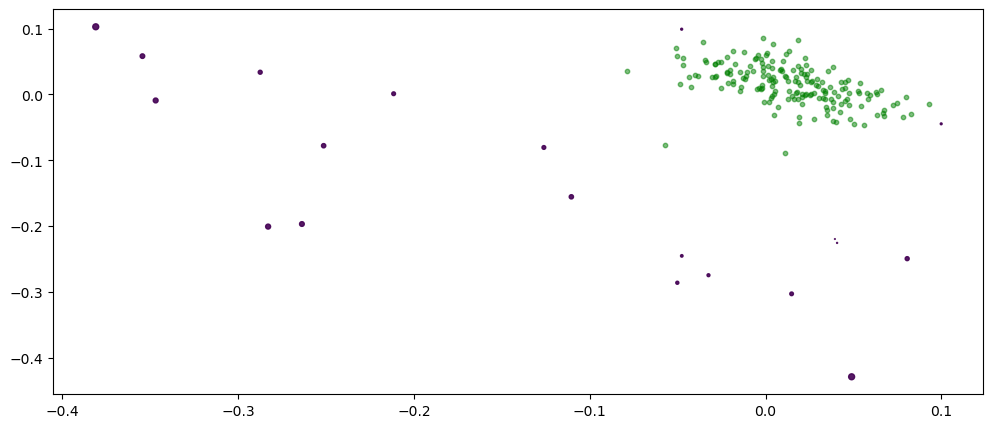

In [32]:
bespoke_pipeline.plot(dataset, non_outliers={'color': 'green'})